<div class="alert alert-info">

#### **MLP Experiment**

In this notebook we are going to train a simple linear classifier on the climbing dataset.

</div>

In [3]:
%load_ext autoreload
%autoreload 2

<div class="alert alert-info">

#### **1- Preliminary**

We first do a preliminary work to prepare the datasets. In order to know more about this, please read the `experiments/preliminary.ipynb` notebook.

</div>

In [4]:
from experiments.helpers.preliminary import preliminary

In [5]:
datasets, filtered_datasets, extractors = preliminary()

/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/Users/nadir/Documents/code/.venv/lib/python3.12/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


[missing-keys]: <All keys matched successfully>


Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main
Using cache found in /Users/nadir/.cache/torch/hub/facebookresearch_pytorchvideo_main


[INFO]: frames for "climb_1-climber_MoubeAdrian-bloc_1-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_1-climber_MoubeAdrian-bloc_1-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_10-climber_DouglasSophia-bloc_1-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_10-climber_DouglasSophia-bloc_1-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_11-climber_MoubeAdrian-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_11-climber_MoubeAdrian-bloc_2-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_12-climber_MrideEsteban-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_12-climber_MrideEsteban-bloc_2-angle_profile" already exist. skipping extraction.
[INFO]: frames for "climb_13-climber_FonneLana-bloc_2-angle_face" already exist. skipping extraction.
[INFO]: frames for "climb_13-climber_FonneLana-blo

<div class="alert alert-info">

#### **2- Model Creation**

Now we'll create the model on which we'll train the features we just extracted.

</div>

In [6]:
import torch

class SimpleLinearClassifier(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleLinearClassifier, self).__init__()
        
        self.network = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.LazyLinear(out_features=output_size)
        )
        
    def forward(self, x):
        return self.network(x)

<div class="alert alert-info">

#### **3- Training**

Below we'll train our model on the different extracted features. We'll run several trainings with different feature extractors in order to do cross validation and have an accurate estimation of the model's performance.

The `Trainer` class is simply a class that takes the model and train it for a given number of epochs.

</div>

In [7]:
class WrapperDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        if self.transform:
            return self.transform(self.dataset[index])
        else:
            return self.dataset[index]
        
    def __len__(self):
        return len(self.dataset)

In [8]:
def transform(sample):
    features, annotations, video_id, segment_index = sample
    
    return features, annotations[0]

In [9]:
NUMBER_OF_FOLDS = 5
NUMBER_ANNOTATED_VIDEOS = 22

from helpers.trainer import Trainer
from utils import LabelEncoderFactory

from experiments.helpers.splits_generator import splits_generator
from experiments.helpers.videos_to_indices import videos_to_indices

label_encoder = LabelEncoderFactory.get()

folds_histories: list[dict] = []

for fold_index, folds in enumerate(splits_generator(dataset_length=NUMBER_ANNOTATED_VIDEOS, k=NUMBER_OF_FOLDS)):
    histories = {}
    
    for dataset, extractor in zip(filtered_datasets, extractors):
        training_videos_ids, validation_videos_ids = folds
    
        training_samples_ids = videos_to_indices(dataset, training_videos_ids)
        testing_samples_ids = videos_to_indices(dataset, validation_videos_ids)
        
        training_dataset = WrapperDataset(torch.utils.data.Subset(dataset, training_samples_ids), transform)
        validation_dataset = WrapperDataset(torch.utils.data.Subset(dataset, testing_samples_ids), transform)
        
        training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True)
        training_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)
    
        linear_classifier = SimpleLinearClassifier(input_size=training_dataset[0][0].shape[0], output_size=len(label_encoder.classes_))
        
        trainer = Trainer(linear_classifier)
        
        history, best_training_accuracy, best_validation_accuracy, best_epoch = trainer.train(training_dataloader, training_dataloader, title=f"[training-{extractor.get_name()}-{fold_index + 1}/{NUMBER_OF_FOLDS}]")
        
        histories[extractor.get_name()] = {
            "history": history,
            "best_training_accuracy": best_training_accuracy,
            "best_validation_accuracy": best_validation_accuracy,
            "best_epoch": best_epoch
        }
        
    folds_histories.append(histories)

[training-slowfast-5/5]: 100%|██████████| 32/32 [00:03<00:00,  8.54epoch/s, training-loss=0.624, training-accuracy=0.821, validation-loss=0.699, validation-accuracy=0.775, best-validation-accuracy=0.775, best-training-accuracy=0.821]


<div class="alert alert-info">

#### **4- Results**

Below we are going to display the training results for each model.

</div>

In [10]:
# NOTE: For each model we are going to put a plot, a box plot or something to display the variance of the validation accuracy between each fold
models_training_accuracies = {}
models_validation_accuracies = {}

for fold_history in folds_histories:
    for extractor_name, details in fold_history.items():
        if models_validation_accuracies.get(extractor_name) is None:
            models_validation_accuracies[extractor_name] = [details["best_validation_accuracy"]] 
        else:
            models_validation_accuracies[extractor_name].append(details["best_validation_accuracy"])
            
        if models_training_accuracies.get(extractor_name) is None:
            models_training_accuracies[extractor_name] = [details["best_training_accuracy"]] 
        else:
            models_training_accuracies[extractor_name].append(details["best_training_accuracy"])

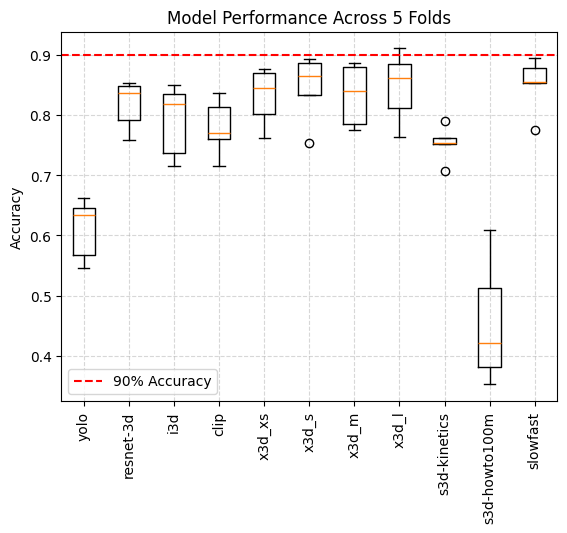

[yolo]: 0.61 ± 0.05; (0.55, 0.66)
[resnet-3d]: 0.82 ± 0.04; (0.76, 0.85)
[i3d]: 0.79 ± 0.05; (0.71, 0.85)
[clip]: 0.78 ± 0.04; (0.71, 0.84)
[x3d_xs]: 0.83 ± 0.04; (0.76, 0.88)
[x3d_s]: 0.85 ± 0.05; (0.75, 0.89)
[x3d_m]: 0.83 ± 0.05; (0.77, 0.89)
[x3d_l]: 0.85 ± 0.05; (0.76, 0.91)
[s3d-kinetics]: 0.75 ± 0.03; (0.71, 0.79)
[s3d-howto100m]: 0.46 ± 0.09; (0.35, 0.61)
[slowfast]: 0.85 ± 0.04; (0.77, 0.90)


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# --- --- ---
            
plt.boxplot(models_validation_accuracies.values(), tick_labels=models_validation_accuracies.keys())

plt.title("Model Performance Across 5 Folds")

plt.ylabel("Accuracy")

plt.xticks(rotation=90)

plt.axhline(y=0.9, color='r', linestyle='--', label='90% Accuracy')

plt.legend()

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

for model_name, accuracies in models_validation_accuracies.items():
    average_accuracy = np.mean(accuracies)
    min_accuracy, max_accuracy = np.min(accuracies), np.max(accuracies)
    std = np.std(accuracies)
    
    print(f"[{model_name}]: {average_accuracy:.2f} ± {std:.2f}; ({min_accuracy:.2f}, {max_accuracy:.2f})")

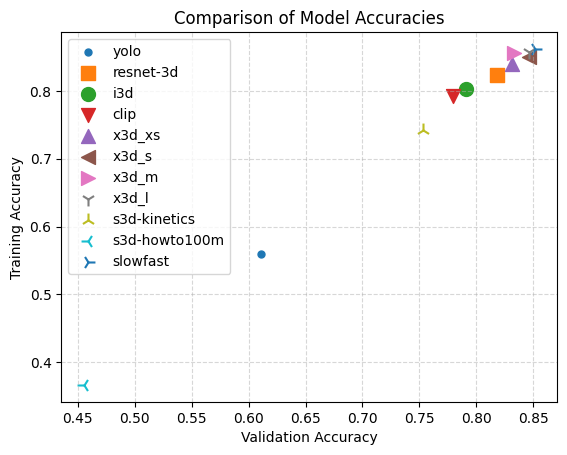

In [21]:
from matplotlib.lines import Line2D

models_names = models_validation_accuracies.keys()

markers = list(Line2D.markers.keys())
markers = markers[:len(models_names)]

for i, model_name, marker in zip(range(len(models_names)), models_names, markers):
    model_average_validation_accuracy = np.mean(models_validation_accuracies[model_name])
    model_average_training_accuracy = np.mean(models_training_accuracies[model_name])
    
    plt.scatter(model_average_validation_accuracy, model_average_training_accuracy, label=model_name, marker=marker, s=100)
    # plt.text(model_average_validation_accuracy, model_average_training_accuracy - 0.02, model_name, ha='center', fontsize=10, fontweight='bold')

plt.xlabel("Validation Accuracy")
plt.ylabel("Training Accuracy")

plt.title("Comparison of Model Accuracies")

plt.legend()

plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

---

### About Dino

<div class="alert alert-info">

**Dino Model Card:** https://github.com/facebookresearch/dinov2/blob/main/MODEL_CARD.md

**Dino for Video Classification:** https://github.com/facebookresearch/dinov2/issues/16

**Note on UniformTemporalSubSample Size:** Increasing it will give better results but increase loading time. https://github.com/facebookresearch/dinov2/issues/16#issuecomment-1521403076

</div>

<div class="alert alert-warning">

**`patchtokens`** are the image token / patches embeddings after they have been passed through the network and the 324 is here because we have a total of 324 patches.

**`clstoken`** is the cls token that is supposed to contain all the relevant information about the image.

**`regtokens`** are regularization tokens and they only help improve feature diversity and representation during training. Only 4 are used in this model.

**`prenorm`** is represent the combined tokens before the layer normalization (1 [CLS Token] + 4 Regularization Tokens + 324 Patch Tokens = 329).

The 768 is the patch embedding size that is used by Deno. And the 16 that keeps reappearing is the batch size since we are using a sample of 16 frames.

```bash
[features.keys()]: dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])
[number_of_patches]: 324
[x_norm_clstoken]: torch.Size([16, 768])
[x_norm_regtokens]: torch.Size([16, 4, 768])
[x_norm_patchtokens]: torch.Size([16, 324, 768])
[x_prenorm]: torch.Size([16, 329, 768])
[masks]: None
```

</div>

<div class="alert alert-success">

**Questions**
- [ ] Why are we using the last hidden state rather than the last memory cell or output ?

</div>

---

### About I-Jepa

<div class="alert alert-warning">


- [ ] **Checkout** [This Site](https://paperswithcode.com/sota/action-classification-on-kinetics-600?p=video-swin-transformer) for a leaderboard on video classification task.

- [ ] Experiment with features from I-Jepa
- [ ] Experiment with features from VideoMAE-ViT-H/16; OmniMAE-ViT-H/16 and VideoMAEv2-ViT-g/14 and other ViT based models for features extraction.
- [ ] Experiment on fine tuning ViT for a specific task using some unlabelled videos or reinforcement learning.
- [ ] Try to perform some sort of clustering and visualizations on using Umap and PCA on these extracted features on different models, do this for features from different models such as ViT, resnet, Video CNNs, etc.

</div>

<div class="alert alert-warning">

- [ ] Is this [Repository](https://github.com/kylemin/S3D) the same as the one we took the S3D model from ?

</div>

<div class="alert alert-info">

**Introduction Video About Image-Jepa:** https://www.youtube.com/watch?v=6bJIkfi8H-E

**V-Jepa Paper:** [Here](https://scontent-lhr8-2.xx.fbcdn.net/v/t39.2365-6/427986745_768441298640104_1604906292521363076_n.pdf?_nc_cat=103&ccb=1-7&_nc_sid=3c67a6&_nc_ohc=G-D4kApr8TQQ7kNvgFSoEBh&_nc_oc=AdiZo1b5QaDaQaf0hctrozKJ2vjIp_iQvUZxArm_8k3ngVZNVLtltyVFidEIN-Njt9g&_nc_zt=14&_nc_ht=scontent-lhr8-2.xx&_nc_gid=AzzCS9ed8AZ-B2iLuVB7EE0&oh=00_AYB3kfkI_sVH0UVTrzunG99_ThmOVCNN7sRu9q9XS7nAPw&oe=67BCDFF1).

</div>

### About YOLO

<div class="alert alert-info">

`keypoints = torch.tensor(result.keypoints[0].xyn)`. the `xyn` gives the normalized version of the `xy` keypoints, the "n" stands for "normalized".

</div>